In [1]:
# Importando dependências

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import math
import os
! pip install patool
import patoolib

In [2]:
# Descomprimindo arquivo .rar e lendo o dataset
try:
    patoolib.extract_archive("vehicles.rar", outdir=os.getcwd())
    os.remove("vehicles.rar")
except:
    pass
Dataset = pd.read_csv('vehicles.csv')
Dataset = Dataset.iloc[28: , :]
Dataset.head(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.5920,-85.518900,2021-05-03T14:02:03-0500
32,7316343444,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,...,NaN,pickup,black,https://images.craigslist.org/00V0V_ftJbKrOgdi...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T13:41:25-0500
33,7316304717,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,...,NaN,pickup,silver,https://images.craigslist.org/00E0E_iKN07Sh7ou...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T12:41:33-0500
34,7316285779,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,35000,2019.0,toyota,tacoma,excellent,6 cylinders,...,NaN,truck,grey,https://images.craigslist.org/00101_dXoZTH7iVm...,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,NaN,al,32.6013,-85.443974,2021-05-03T12:12:59-0500
35,7316257769,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T11:31:14-0500
36,7316133914,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,...,NaN,other,red,https://images.craigslist.org/00U0U_kKYnS1LWh8...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T07:50:35-0500
37,7316130053,https://auburn.craigslist.org/cto/d/opelika-19...,auburn,https://auburn.craigslist.org,4500,1992.0,jeep,cherokee,excellent,6 cylinders,...,NaN,NaN,NaN,https://images.craigslist.org/01010_7EM2aot64G...,192k miles brand new TSLs 4x4 jeep xj. 4x4 wor...,NaN,al,32.6454,-85.378300,2021-05-03T07:38:05-0500


# Quanto vale seu carro usado no Craigslist?

### A partir da análise de dados como quilometragem, ano do modelo, estado de conservação, tipo de combustível, entre outros, pretendemos prever o preço de revenda de um carro na plataforma Craigslist.   

# Análise exploratória -- Preços

Preço é a variável target do modelo. Assim, é de interesse analisar quais são os fatores fundamentais que influenciam em seu valor. Nesse sentido, através de gráficos de dispersão, histogramas e outras ferramentas estatísticas, determinaremos as features a serem consideradas.

clean         0.967702
rebuilt       0.017244
salvage       0.009240
lien          0.003397
missing       0.001944
parts only    0.000473
Name: title_status, dtype: float64


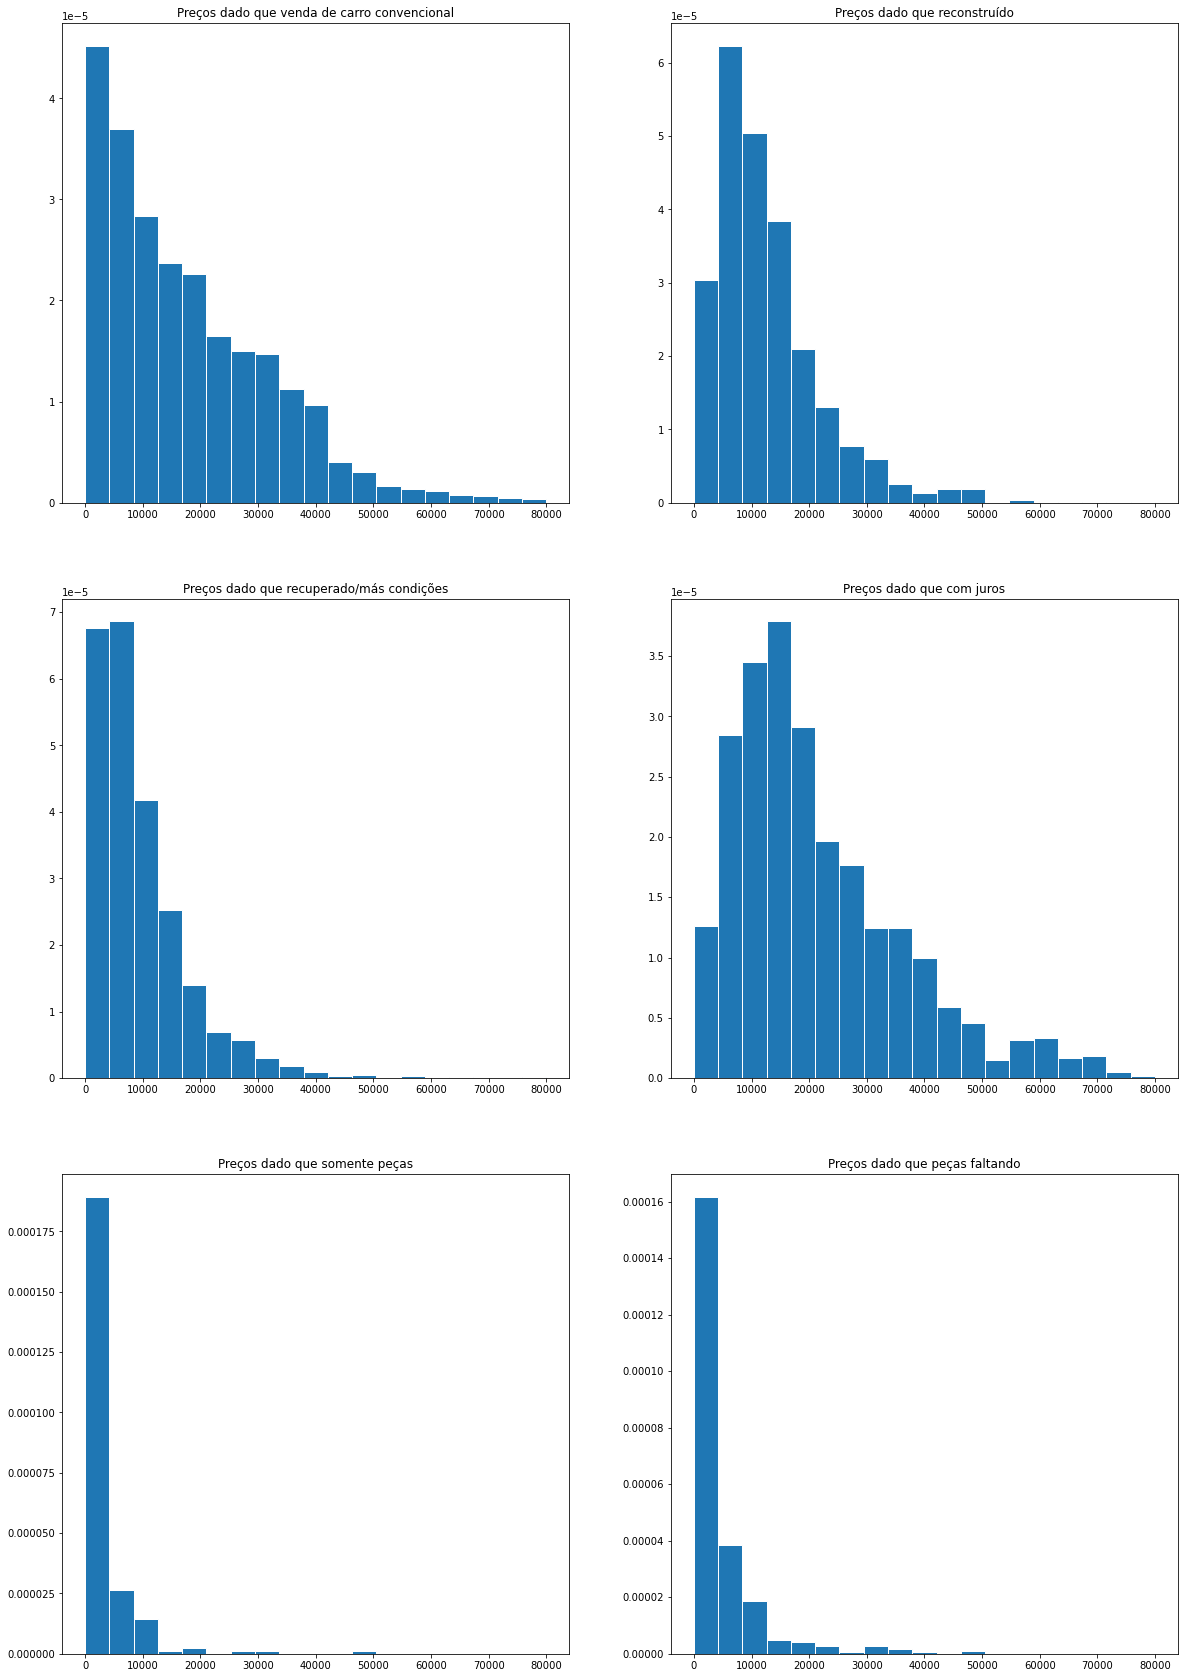

In [5]:
# Primeiramente, devemos decidir quais são as condições que o modelo assume. Imaginamos que venda de peças de carros
# ou de carros com peças faltando são casos significativamente diferentes do que a de um carro convencional. 

print(Dataset.title_status.value_counts(normalize=True))

# Para observar as diferenças:

bins = np.linspace(0,8e+4,20)

plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Preços dado que venda de carro convencional')
plt.hist(Dataset.loc[Dataset.title_status == 'clean']['price'],bins,edgecolor='white',density=True)
plt.subplot(322)
plt.title('Preços dado que reconstruído')
plt.hist(Dataset.loc[Dataset.title_status == 'rebuilt']['price'],bins,edgecolor='white',density=True)
plt.subplot(323)
plt.title('Preços dado que recuperado/más condições')
plt.hist(Dataset.loc[Dataset.title_status == 'salvage']['price'],bins,edgecolor='white',density=True)
plt.subplot(324)
plt.title('Preços dado que com juros')
plt.hist(Dataset.loc[Dataset.title_status == 'lien']['price'],bins,edgecolor='white',density=True)
plt.subplot(325)
plt.title('Preços dado que somente peças')
plt.hist(Dataset.loc[Dataset.title_status == 'parts only']['price'],bins,edgecolor='white',density=True)
plt.subplot(326)
plt.title('Preços dado que peças faltando')
plt.hist(Dataset.loc[Dataset.title_status == 'missing']['price'],bins,edgecolor='white',density=True)
plt.show()



# Conclusão:

Percebe-se que os preços de peças, carros com peça faltando e em más condições destoam bastante do convencional por praticamente não serem vendidos à valores mais altos. Já no caso de carros "com juros" (car lien é a venda de um carro em parcelas, na qual o vendedor cobra juros por segurança, podendo recuperar o carro caso não seja pago), eles costumam ter valores maiores que carros convencionais. Para carros reconstruídos, eles não cotumam ser vendidos por preços muito baixos, mas tendem a ter preços menores que o convencional na maioria dos casos.

Como a maioria (cerca de 96%) da base de dados é composta por carros convencionais, e as categorias restantes possuem distribuições significativamente diferentes, escolhemos filtrar o modelo para venda de carros convencionais.

count    4.051160e+05
mean     7.844389e+04
std      1.250520e+07
min      0.000000e+00
25%      5.959000e+03
50%      1.399700e+04
75%      2.699000e+04
max      3.736929e+09
Name: price, dtype: float64


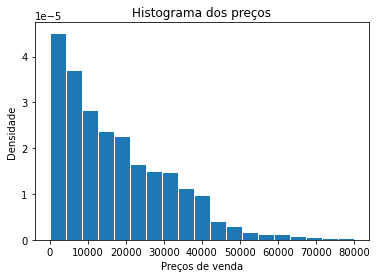

In [6]:
# Histograma de preços 

dados = Dataset.loc[Dataset.title_status == 'clean',:]

# Valores de interesse para basear as faixas
print(dados.price.describe())

bins = np.linspace(0,8e+4,20)

plt.hist(dados.price,bins=bins,edgecolor='white',density=True)
plt.title('Histograma dos preços')
plt.xlabel('Preços de venda')
plt.ylabel('Densidade')
plt.show()

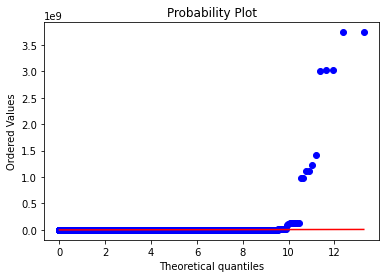

In [51]:
# O gráfico se assemelha com uma exponencial, para verificar temos que: 

stats.probplot(dados.price,dist='expon',plot=plt)
plt.show()

0.010648458498299334


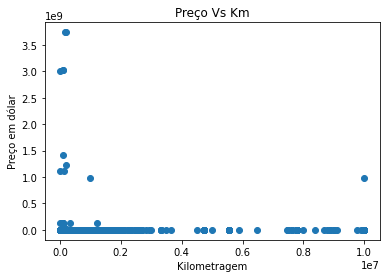

In [52]:
# Kilometragem e preço são relacionados?

print(dados.price.corr(dados.odometer))

plt.scatter(dados.odometer,dados.price)
plt.title('Preço Vs Km')
plt.ylabel('Preço em dólar')
plt.xlabel('Kilometragem')
plt.show()

# Correlação bem fraca e positiva

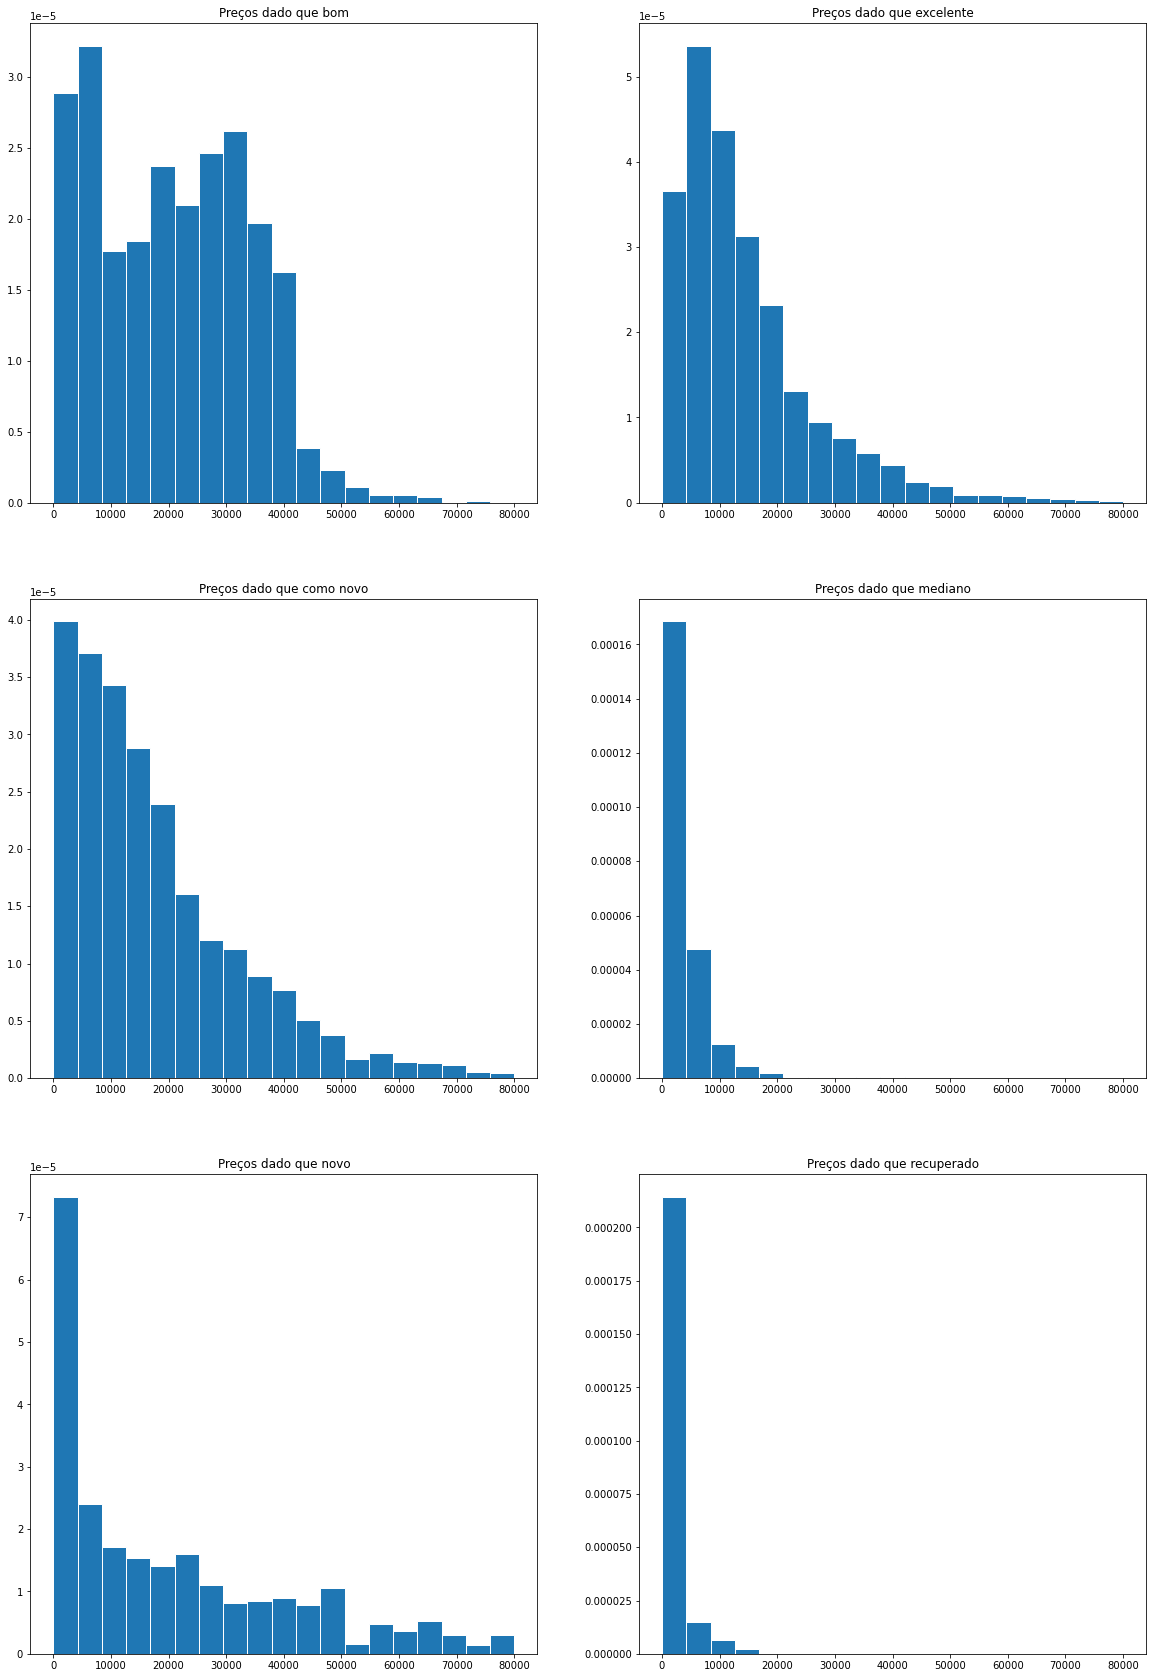

In [53]:
# Preço e condição se relacionam?

plt.figure(figsize=(20,30))
plt.subplot(321)
plt.title('Preços dado que bom')
plt.hist(dados.loc[dados.condition == 'good']['price'],bins,edgecolor='white',density=True)
plt.subplot(322)
plt.title('Preços dado que excelente')
plt.hist(dados.loc[dados.condition == 'excellent']['price'],bins,edgecolor='white',density=True)
plt.subplot(323)
plt.title('Preços dado que como novo')
plt.hist(dados.loc[dados.condition == 'like new']['price'],bins,edgecolor='white',density=True)
plt.subplot(324)
plt.title('Preços dado que mediano')
plt.hist(dados.loc[dados.condition == 'fair']['price'],bins,edgecolor='white',density=True)
plt.subplot(325)
plt.title('Preços dado que novo')
plt.hist(dados.loc[dados.condition == 'new']['price'],bins,edgecolor='white',density=True)
plt.subplot(326)
plt.title('Preços dado que recuperado')
plt.hist(dados.loc[dados.condition == 'salvage']['price'],bins,edgecolor='white',density=True)
plt.show()
